# Particle Flow Test 1

Make our own particle flow network, train it on top tagging dataset

In [21]:
# Up to a minute to import everything
# Make tensorflow quieter
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# Computing imports
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

# Useful imports
from tqdm import tqdm
import matplotlib.pyplot as plt

# Energyflow imports
import energyflow as ef
from energyflow.utils import data_split, to_categorical

## Import, preprocess data

Data lives in `X_train`, `X_val`, `X_test`, and `Y_train`, `Y_val`, `Y_test`.

In [2]:
# ~5 sec
jets_path = "/usatlas/atlas01/atlasdisk/users/atlas_wifeng/photon-jet/data/processed/scalar_test/all_jets_point_cloud.npz"
jets = np.load(jets_path)

X, y = jets["X"], jets["y"]
Y = to_categorical(y)

print("Loaded data")

Loaded data


In [4]:
# ~5 sec
# Do train/val/test split
n_val = 20000
n_test = 20000

(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, val=n_val, test=n_test)

print("Done train/val/test split")

Done train/val/test split


## Define the model

PFN model:
$$\text{PFN}=F\left(\sum_{i=1}^M \Phi(p_i)\right)$$

In [5]:
def PFN(n_features,
        n_particles,
        n_outputs,
        Phi_sizes,
        F_sizes,
        name=None):
    
        inputs = layers.Input((n_particles, n_features), name="input")    
        masking_layer = layers.Masking(
            mask_value=0.,
            input_shape=(n_particles, n_features)
        )
        Phi_layers = [layers.Dense(size, activation="relu", name=f"Phi_{i}") for i, size in enumerate(Phi_sizes)]
        F_layers = [layers.Dense(size, activation="relu", name=f"F_{i}") for i, size in enumerate(F_sizes)]
        last_layer = layers.Dense(n_outputs, name="output")
        
        x = masking_layer(inputs)
        for layer in Phi_layers:
            x = layers.TimeDistributed(layer)(x)
        x = tf.math.reduce_sum(x, axis=1)
        for layer in F_layers:
            x = layer(x)
        x = last_layer(x)
        
        return tf.keras.Model(inputs=inputs, outputs=x)

## Compile and train the model

In [43]:
# Takes about 5 sec the first time
# Training hyperparameters
lr = 1e-3
epochs = 5
batch_size = 10

# Data dimensions
n_features = 4
n_particles = 960

model = PFN(
    n_features=n_features,
    n_particles=n_particles,
    n_outputs=3,
    Phi_sizes=[256, 256, 128, 64],
    F_sizes=[256, 256, 128, 64]
)

In [44]:
tf.keras.backend.clear_session()
tf.config.experimental.get_memory_info("GPU:0")

{'current': 4001730816, 'peak': 9288965888}

In [45]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 960, 4)]          0         
                                                                 
 masking (Masking)           (None, 960, 4)            0         
                                                                 
 time_distributed (TimeDistr  (None, 960, 256)         1280      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 960, 256)         65792     
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 960, 128)         32896     
 tributed)                                                       
                                                             

In [46]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [47]:
history = model.fit(X_train, Y_train,
                    epochs=5,
                    batch_size=500,
                    validation_data=(X_val, Y_val),
                    verbose=1)

Epoch 1/5
520/520 [==============================] - 57s 102ms/step - loss: 36.0719 - accuracy: 0.3352 - val_loss: 1.1314 - val_accuracy: 0.3589
Epoch 2/5
520/520 [==============================] - 52s 101ms/step - loss: 7.3452 - accuracy: 0.3398 - val_loss: 2.0236 - val_accuracy: 0.3359
Epoch 3/5
520/520 [==============================] - 53s 101ms/step - loss: 1.4189 - accuracy: 0.3378 - val_loss: 1.1056 - val_accuracy: 0.3546
Epoch 4/5
520/520 [==============================] - 53s 101ms/step - loss: 1.1040 - accuracy: 0.3518 - val_loss: 1.0883 - val_accuracy: 0.4176
Epoch 5/5
520/520 [==============================] - 52s 101ms/step - loss: 1.0584 - accuracy: 0.4184 - val_loss: 1.0416 - val_accuracy: 0.4516


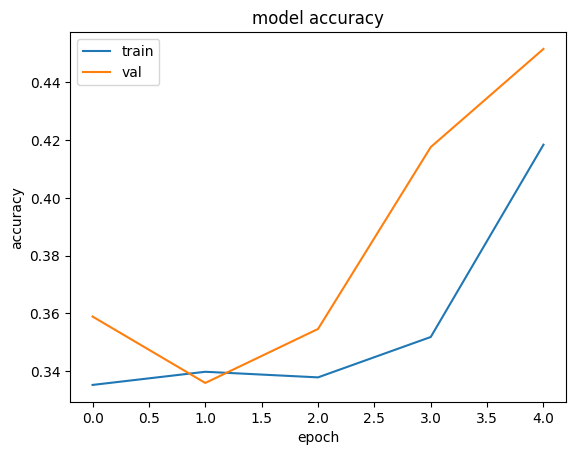

In [48]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

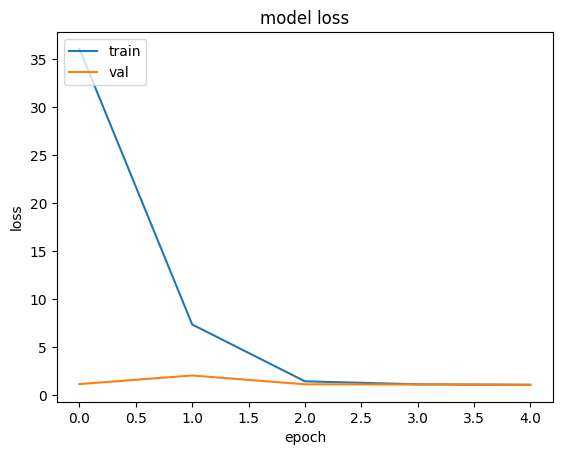

In [49]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [50]:
# get predictions on test data
preds = model.predict(X_test, batch_size=500)

40/40 [==============================] - 1s 30ms/step


In [51]:
test_labels = np.argmax(Y_test, axis=1)
pred_labels = np.argmax(preds, axis=1)

mask = (test_labels == pred_labels).astype(float)
print(mask)
print(f"Test accuracy: {mask.mean()}")

[1. 1. 1. ... 1. 0. 1.]
Test accuracy: 0.45145


Total test jets: 20000


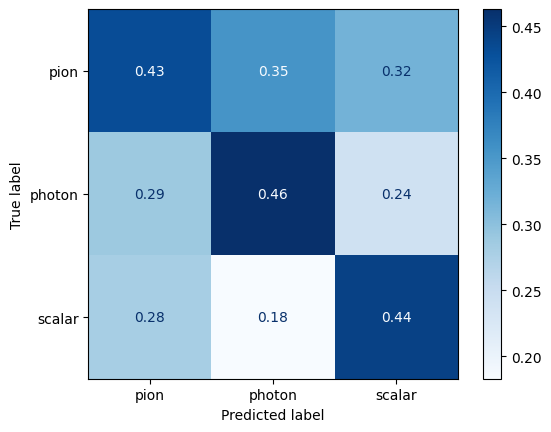

In [52]:
cm = confusion_matrix(test_labels, pred_labels).astype(float)
cm /= np.sum(cm, axis=0, keepdims=True)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["pion", "photon", "scalar"]
);
disp.plot(cmap="Blues");

print(f"Total test jets: {len(test_labels)}")